In [9]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

class Tp(object):
    
    def __init__(self):
        self.decisionNode = dict(boxstyle='sawtooth', fc='10')
        self.leafNode = dict(boxstyle='round4',fc='0.8')
        self.arrow_args = dict(arrowstyle='<|-')

    def plotNode(self, nodeTxt, centerPt, parentPt, nodeType):
        createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',\
                                 xytext=centerPt,textcoords='axes fraction',\
                                 va='center', ha='center',bbox=nodeType,arrowprops\
                                 =self.arrow_args)

    def getNumLeafs(self, myTree):
        numLeafs = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                numLeafs += getNumLeafs(secondDict[key])
            else:
                numLeafs += 1
        return numLeafs

    def getTreeDepth(self, myTree):
        maxDepth = 0
        firstStr = list(myTree.keys())[0]
        secondDict = myTree[firstStr]
        for key in secondDict:
            if(type(secondDict[key]).__name__ == 'dict'):
                thisDepth = 1 + getTreeDepth((secondDict[key]))
            else:
                thisDepth = 1
            if thisDepth > maxDepth: maxDepth = thisDepth
        return maxDepth

    def retrieveTree(self, i):
        #预先设置树的信息
        listOfTree = [{'no surfacing':{0:'no', 1:{'flipper':{0:'no', 1:'yes'}}}},
                      {'no surfacing':{0:'no', 1:{'flipper':{0:{'head':{0:'no', 1:'yes'}},1:'no'}}}},
                      {'a1':{0:'b1', 1:{'b2':{0:{'c1':{0:'d1',1:'d2'}}, 1:'c2'}}, 2:'b3'}}]
        return listOfTree[i]

    def createPlot(self, inTree):
        fig = plt.figure(1,facecolor='white')
        fig.clf()
        axprops = dict(xticks = [], yticks=[])
        createPlot.ax1 = plt.subplot(111,frameon = False,**axprops)
        plotTree.totalW = float(getNumLeafs(inTree))
        plotTree.totalD = float(getTreeDepth(inTree))
        plotTree.xOff = -0.5 / plotTree.totalW;plotTree.yOff = 1.0
        plotTree(inTree,(0.5,1.0), '')
        plt.show()

    def plotMidText(self, cntrPt, parentPt,txtString):
        xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
        yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
        createPlot.ax1.text(xMid, yMid, txtString)

    def plotTree(self, myTree, parentPt, nodeTxt):
        numLeafs = getNumLeafs(myTree)
        depth = getTreeDepth(myTree)
        firstStr = list(myTree.keys())[0]
        cntrPt = (plotTree.xOff+(1.0+float(numLeafs))/2.0/plotTree.totalW,\
                  plotTree.yOff)
        plotMidText(cntrPt,parentPt,nodeTxt)
        plotNode(firstStr,cntrPt,parentPt,self.decisionNode)
        secondDict = myTree[firstStr]
        plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
        for key in secondDict:
            if type(secondDict[key]).__name__ == 'dict':
                plotTree(secondDict[key],cntrPt,str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
                plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),\
                         cntrPt,self.leafNode)
                plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
        plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

NameError: name 'createPlot' is not defined

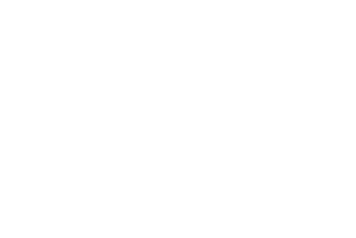

In [10]:
tp = Tp()
myTree = tp.retrieveTree(2)
tp.createPlot(myTree)

## 4.3

In [ ]:
import random, math
data3 = pd.read_csv('./data3_full.csv')
print (data3.columns)
data3 = data3.drop(axis=1,columns=['编号','密度', '含糖率'])

In [ ]:
class TreeNode(object):
    def __init__(self, idx, data, par, val = None):
        self.idx = idx
        self.feature = None
        self.val = val
        self.ch = set()
        self.data = data
        self.n = len(data)
    
class DecisionTree(object):
    
    def __init__(self, data):
        self.data = data
        self.n = len(data)
        self.nodes = {}
        self.nodes[0] = TreeNode(0, self.data, -1)
        self.tot = 1
        self.tree = {}
        
    def add_node(self, data, val = None):
        self.nodes[self.tot] = TreeNode(self.tot, data, val)    
        self.tot += 1
        return self.tot - 1

    def Entropy(self, p1):
        if p1 < 1e-6 or p1 > 1.0 - 1e-6:
            return 0
        else:
            return -(p1 * math.log2(p1) + (1 - p1) * math.log2(1 - p1))
    
    def Gain(self, data, feature):
        import math
        p1 = len(data[data[data.columns[-1]] == '是']) / float(len(data))
        gain = self.Entropy(p1)
        groups = data.groupby(feature)
        for dat in groups:
            dat = dat[1]
            p1 = len(dat[dat[dat.columns[-1]] == '是']) / float(len(dat))
            gain -= len(dat) / float(len(data)) * self.Entropy(p1)
        return gain
    
    def sel_feature(self, data): 
        best_feature, max_gain = None, -1e9
        for feature in data.columns[:-1]:
            cur_gain = self.Gain(data, feature)
            if cur_gain > max_gain + 1e-6:
                best_feature, max_gain = feature, cur_gain
        return best_feature
    
    def to_end(self, data):
        if len(data) == 1:
            return True
        if len(data.groupby(data.columns[-1])) == 1:
            return True
        one_class = True
        for feature in data.columns[:-1]:
            if len(data.groupby(feature)) > 1:
                one_class = False
                break
        if one_class:
            return True
        return False
        
    def dfs(self, data, cur = 0, par = -1):
        
        if self.to_end(data):
            if len(data[data[data.columns[-1]] == '是']) * 2.0 > len(data):
                self.nodes[cur].val = '是'
            elif len(data[data[data.columns[-1]] == '否']) * 2.0 > len(data):
                self.nodes[cur].val = '否'
            else:
                self.nodes[cur].val = "是否"[random.randint(0,1)]
            return
        
        feature = self.sel_feature(data)
        self.nodes[cur].feature = feature
        
        feature_vals = set(data[feature].values)
        if feature_vals != None:
            for val in feature_vals:
                data_cur = data[data[feature] == val]
                nxt = self.add_node(feature, data_cur)
                self.nodes[cur].ch.add(nxt)
                self.dfs(data_cur, nxt, cur)
        
        print (self.nodes[cur].feature, self.nodes[cur].idx, self.nodes[cur].ch)

        
    def get_tree(self, cur = 0, par = -1):
        if self.nodes[cur].val != None:
            return self.nodes[cur].val
        else:
            cur_tree = {}
            for (cnt, nxt) in enumerate(self.nodes[cur].ch):
                cur_tree[cnt] = self.get_tree(nxt, cur)
            return {self.nodes[cur].feature: cur_tree}

In [ ]:
[{'a1':{0:'b1', 1:{'b2':{0:{'c1':{0:'d1',1:'d2'}}, 1:'c2'}}, 2:'b3'}}]

In [ ]:
tree

In [ ]:
dt = DecisionTree(data3)
dt.dfs(dt.data)

In [ ]:
tree = dt.get_tree()
tp = Tp()
tp.createPlot(tree)